In [13]:
code = """
import bpy
import os
import math
import random
from mathutils import Vector
import csv

import platform
if platform.system() == "Windows":
    output_dir = os.path.join(os.path.expanduser("~"), "Desktop", "SpheroRender")
else:
    output_dir = os.path.join(os.path.expanduser("~/Desktop/SpheroRender"))


if bpy.app.version < (2, 83, 0):
    print("Warning: This script was developed for Blender 2.83+")

scene = bpy.context.scene
scene.render.fps = 60
scene.frame_start = 1
scene.frame_end = 120

bpy.context.scene.frame_set(scene.frame_start)

# Clear existing objects
bpy.ops.object.select_all(action='SELECT')
bpy.ops.object.delete()

# Set up rendering
scene = bpy.context.scene
scene.render.engine = 'BLENDER_EEVEE_NEXT' # Changed to Eevee
scene.eevee.taa_samples = 64       # Temporal Anti-Aliasing samples
scene.render.resolution_x = 1920
scene.render.resolution_y = 1080
scene.render.fps = 60


# Create ground plane
bpy.ops.mesh.primitive_plane_add(size=50, location=(0, 0, 0))
ground = bpy.context.active_object
ground.name = "Ground"

# Add material to ground
mat = bpy.data.materials.new(name="GroundMaterial")
mat.use_nodes = True
nodes = mat.node_tree.nodes
bsdf = nodes.get("Principled BSDF")
bsdf.inputs["Base Color"].default_value = (0.2, 0.2, 0.2, 1.0)
ground.data.materials.append(mat)

# Create wall
bpy.ops.mesh.primitive_cube_add(size=1, location=(0, 13, 0.25))
wall = bpy.context.active_object
wall.name = "Wall"
wall.scale = (20, 0.5, 4)
wall.location = (0, 15, 2)

# Add material to wall
mat = bpy.data.materials.new(name="WallMaterial")
mat.use_nodes = True
nodes = mat.node_tree.nodes
bsdf = nodes.get("Principled BSDF")
bsdf.inputs["Base Color"].default_value = (0.8, 0.8, 0.8, 1.0)
wall.data.materials.append(mat)

# Create energy absorption barrier
def create_barrier():
    # Base structure
    bpy.ops.mesh.primitive_cube_add(size=1, location=(0, 13, 1))
    base = bpy.context.active_object
    base.name = "BarrierBase"
    base.scale = (15, 1, 0.5)

    # Add material to base
    mat = bpy.data.materials.new(name="BaseMaterial")
    mat.use_nodes = True
    nodes = mat.node_tree.nodes
    bsdf = nodes.get("Principled BSDF")
    bsdf.inputs["Base Color"].default_value = (0.5, 0.3, 0.1, 1.0)
    base.data.materials.append(mat)

    # High-density foam backing
    bpy.ops.mesh.primitive_cube_add(size=1, location=(0, 13.6, 0.85))
    backing = bpy.context.active_object
    backing.name = "FoamBacking"
    backing.scale = (14, 0.5, 1.2)
    backing.location = (0, 13.6, 0.85)

    # Add material to backing
    mat = bpy.data.materials.new(name="BackingMaterial")
    mat.use_nodes = True
    nodes = mat.node_tree.nodes
    bsdf = nodes.get("Principled BSDF")
    bsdf.inputs["Base Color"].default_value = (0.2, 0.4, 0.6, 1.0)
    bsdf.inputs["Roughness"].default_value = 0.9
    backing.data.materials.append(mat)

    # Springs array
    springs = []
    num_springs = 8
    spring_width = 12 / num_springs

    for i in range(num_springs):
        x_pos = -6 + i * spring_width + spring_width/2
        bpy.ops.mesh.primitive_cylinder_add(
            vertices=16,
            radius=0.2,
            depth=0.8,
            location=(x_pos, 14.1, 1.6)
        )
        spring = bpy.context.active_object
        spring.name = f"Spring_{i}"

        # Add spring material
        mat = bpy.data.materials.new(name=f"SpringMaterial_{i}")
        mat.use_nodes = True
        nodes = mat.node_tree.nodes
        bsdf = nodes.get("Principled BSDF")
        bsdf.inputs["Base Color"].default_value = (0.7, 0.7, 0.7, 1.0)
        bsdf.inputs["Metallic"].default_value = 0.9
        spring.data.materials.append(mat)

        # Create spring coil geometry
        bpy.ops.curve.primitive_bezier_circle_add(radius=0.2, location=(x_pos, 14.1, 1.6))
        circle = bpy.context.active_object

        bpy.ops.curve.primitive_bezier_curve_add(location=(x_pos, 14.1, 1.6))
        curve = bpy.context.active_object
        curve.data.dimensions = '3D'
        curve.data.resolution_u = 64
        curve.data.bevel_object = circle

        # Create spring coil shape
        bezier_points = curve.data.splines[0].bezier_points
        bezier_points.add(10-1)  # Add points (minus the one that's already there)

        coil_height = 0.8
        coil_radius = 0.2
        coil_turns = 4

        for j in range(len(bezier_points)):
            t = j / (len(bezier_points) - 1)
            angle = t * coil_turns * 2 * math.pi
            z = t * coil_height
            x = math.cos(angle) * coil_radius
            y = math.sin(angle) * coil_radius

            bezier_points[j].co = (x, y, z)
            bezier_points[j].handle_left_type = 'AUTO'
            bezier_points[j].handle_right_type = 'AUTO'

        # Apply material to spring coil
        curve.data.materials.append(mat)
        springs.append(curve)

        # Remove the cylinder (was just for placement reference)
        bpy.data.objects.remove(spring)
        bpy.data.objects.remove(circle)

    # Impact surface (curved)
    bpy.ops.mesh.primitive_cube_add(size=1, location=(0, 14.7, 1.6))
    impact = bpy.context.active_object
    impact.name = "ImpactSurface"
    impact.scale = (14, 0.3, 1.2)

    # Bend the impact surface to make it concave
    # Add subdiv modifier for smooth bending
    subdiv = impact.modifiers.new(name="Subdivision", type='SUBSURF')
    subdiv.levels = 3
    subdiv.render_levels = 3

    # Add simple deform modifier for bending
    bend = impact.modifiers.new(name="Bend", type='SIMPLE_DEFORM')
    bend.deform_method = 'BEND'
    bend.deform_axis = 'Y'
    bend.angle = -0.5

    # Apply modifiers
    bpy.context.view_layer.objects.active = impact
    bpy.ops.object.modifier_apply(modifier="Subdivision")
    bpy.ops.object.modifier_apply(modifier="Bend")

    # Add material to impact surface
    mat = bpy.data.materials.new(name="ImpactMaterial")
    mat.use_nodes = True
    nodes = mat.node_tree.nodes
    bsdf = nodes.get("Principled BSDF")
    bsdf.inputs["Base Color"].default_value = (0.1, 0.2, 0.7, 1.0)
    bsdf.inputs["Roughness"].default_value = 0.3
    impact.data.materials.append(mat)

    return base, backing, springs, impact

barrier_base, barrier_backing, barrier_springs, barrier_impact = create_barrier()

# Create Sphero Bolt
bpy.ops.mesh.primitive_uv_sphere_add(radius=0.75, location=(-5, 5, 0.75))
sphero = bpy.context.active_object
sphero.name = "Sphero"

# Add material to Sphero
import bpy

# Add material to Sphero
mat = bpy.data.materials.new(name="SpheroMaterial")
mat.use_nodes = True
nodes = mat.node_tree.nodes

# Try to get the Principled BSDF node
bsdf = nodes.get("Principled BSDF")

if bsdf:
    # Set properties on the BSDF if it exists
    bsdf.inputs["Base Color"].default_value = (0.9, 0.9, 0.9, 1.0)
    bsdf.inputs["Metallic"].default_value = 0.2
    bsdf.inputs["Roughness"].default_value = 0.2

    # Check if 'Clearcoat' exists before trying to access it
    if "Clearcoat" in bsdf.inputs:
        bsdf.inputs["Clearcoat"].default_value = 1.0
    else:
        print("Clearcoat input not available in the Principled BSDF node.")
else:
    print("Principled BSDF node not found.")

# Apply the material to the Sphero object
sphero = bpy.context.active_object  # Ensure that the Sphero object is selected
if sphero:
    sphero.data.materials.append(mat)
else:
    print("No active object selected.")


# Set up lighting
def create_lighting():
    # Key light
    bpy.ops.object.light_add(type='AREA', radius=5, location=(10, -10, 15))
    key_light = bpy.context.active_object
    key_light.name = "KeyLight"
    key_light.data.energy = 500
    key_light.data.size = 5

    # Fill light
    bpy.ops.object.light_add(type='AREA', radius=5, location=(-10, -10, 10))
    fill_light = bpy.context.active_object
    fill_light.name = "FillLight"
    fill_light.data.energy = 300
    fill_light.data.size = 7

    # Rim light
    bpy.ops.object.light_add(type='AREA', radius=3, location=(0, -15, 8))
    rim_light = bpy.context.active_object
    rim_light.name = "RimLight"
    rim_light.data.energy = 400
    rim_light.data.size = 3

    # Environment lighting with HDRI
    world = bpy.context.scene.world
    if not world:
        world = bpy.data.worlds.new("World")
        bpy.context.scene.world = world

    world.use_nodes = True
    node_tree = world.node_tree

    # Clear existing nodes
    for node in node_tree.nodes:
        node_tree.nodes.remove(node)

    # Create new nodes
    node_background = node_tree.nodes.new(type='ShaderNodeBackground')
    node_environment = node_tree.nodes.new(type='ShaderNodeTexEnvironment')
    node_output = node_tree.nodes.new(type='ShaderNodeOutputWorld')

    # Connect nodes
    node_tree.links.new(node_environment.outputs["Color"], node_background.inputs["Color"])
    node_tree.links.new(node_background.outputs["Background"], node_output.inputs["Surface"])

    # Position nodes
    node_environment.location = (-300, 0)
    node_background.location = (0, 0)
    node_output.location = (300, 0)

    # Create a simple procedural environment
    mapping = node_tree.nodes.new(type='ShaderNodeMapping')
    tex_coord = node_tree.nodes.new(type='ShaderNodeTexCoord')
    gradient = node_tree.nodes.new(type='ShaderNodeTexGradient')

    node_tree.links.new(tex_coord.outputs["Generated"], mapping.inputs["Vector"])
    node_tree.links.new(mapping.outputs["Vector"], gradient.inputs["Vector"])
    node_tree.links.new(gradient.outputs["Color"], node_background.inputs["Color"])

    # Set gradient colors for a nice studio look
    color_ramp = node_tree.nodes.new(type='ShaderNodeValToRGB')
    color_ramp.color_ramp.elements[0].color = (0.05, 0.05, 0.1, 1.0)
    color_ramp.color_ramp.elements[1].color = (0.2, 0.3, 0.4, 1.0)

    node_tree.links.new(gradient.outputs["Color"], color_ramp.inputs["Fac"])
    node_tree.links.new(color_ramp.outputs["Color"], node_background.inputs["Color"])

    return key_light, fill_light, rim_light

key_light, fill_light, rim_light = create_lighting()

# Set up camera
bpy.ops.object.camera_add(location=(15, -15, 6), rotation=(math.radians(70), 0, math.radians(135)))
camera = bpy.context.active_object
camera.name = "Camera"
bpy.context.scene.camera = camera

# Track camera to look at sphero
track_to = camera.constraints.new(type='TRACK_TO')
track_to.target = sphero
track_to.track_axis = 'TRACK_NEGATIVE_Z'
track_to.up_axis = 'UP_Y'

# Add rigidbody to sphero
bpy.context.view_layer.objects.active = sphero
bpy.ops.rigidbody.object_add()
sphero.rigid_body.mass = 2.0
sphero.rigid_body.restitution = 0.8
sphero.rigid_body.friction = 0.3
sphero.rigid_body.collision_shape = 'SPHERE'
# Explicitly set initial linear velocity to zero
sphero.rigid_body.kinematic = False
sphero.rigid_body.use_deactivation = False


# Linear animation for Sphero - moving straight toward the wall
sphero.rigid_body.kinematic = False
bpy.ops.object.effector_add(type='FORCE',
location=(-5, 5, 0.75))
push_force = bpy.context.active_object
push_force.name = "SpheroPushForce"
push_force.field.strength = 20
push_force.field.falloff_type = 'SPHERE'
push_force.field.use_max_distance = True
push_force.field.distance_max = 1000

# Add rigidbody to wall
bpy.context.view_layer.objects.active = wall
bpy.ops.rigidbody.object_add()
wall.rigid_body.type = 'PASSIVE'
wall.rigid_body.collision_shape = 'BOX'

# Add rigidbody to ground
bpy.context.view_layer.objects.active = ground
bpy.ops.rigidbody.object_add()
ground.rigid_body.type = 'PASSIVE'
ground.rigid_body.collision_shape = 'BOX'

# Add rigidbody to barrier parts
bpy.context.view_layer.objects.active = barrier_base
bpy.ops.rigidbody.object_add()
barrier_base.rigid_body.type = 'PASSIVE'
barrier_base.rigid_body.collision_shape = 'BOX'

bpy.context.view_layer.objects.active = barrier_backing
bpy.ops.rigidbody.object_add()
barrier_backing.rigid_body.type = 'ACTIVE'
barrier_backing.rigid_body.mass = 0.5
barrier_backing.rigid_body.collision_shape = 'BOX'
barrier_backing.rigid_body.kinematic = True  # Will be animated

bpy.context.view_layer.objects.active = barrier_impact
bpy.ops.rigidbody.object_add()
barrier_impact.rigid_body.type = 'ACTIVE'
barrier_impact.rigid_body.mass = 0.3
barrier_impact.rigid_body.collision_shape = 'CONVEX_HULL'
barrier_impact.rigid_body.kinematic = True  # Will be animated


# Add animation for the barrier compression
def animate_barrier_compression():
    # Initial position
    frame_impact = 50  # When the Sphero hits the barrier

    # Keyframe initial positions
    barrier_impact.keyframe_insert(data_path="location", frame=1)
    barrier_backing.keyframe_insert(data_path="location", frame=1)

    # Compressed position (impact phase)
    barrier_impact.location.y -= 0.5  # Move back when compressed
    barrier_impact.keyframe_insert(data_path="location", frame=frame_impact + 5)

    barrier_backing.location.y -= 0.3  # Less movement for backing
    barrier_backing.keyframe_insert(data_path="location", frame=frame_impact + 5)

    # Recovery phase (springs pushing back)
    barrier_impact.location.y += 0.4  # Not fully back to original position
    barrier_impact.keyframe_insert(data_path="location", frame=frame_impact + 15)

    barrier_backing.location.y += 0.2
    barrier_backing.keyframe_insert(data_path="location", frame=frame_impact + 15)

    # Settling phase
    barrier_impact.location.y -= 0.1
    barrier_impact.keyframe_insert(data_path="location", frame=frame_impact + 25)

    barrier_backing.location.y -= 0.05
    barrier_backing.keyframe_insert(data_path="location", frame=frame_impact + 25)

    # Final resting position
    barrier_impact.location.y += 0.05
    barrier_impact.keyframe_insert(data_path="location", frame=frame_impact + 35)

    barrier_backing.location.y += 0.02
    barrier_backing.keyframe_insert(data_path="location", frame=frame_impact + 35)

    # Add easing to make the animation more realistic
    for fcurve in barrier_impact.animation_data.action.fcurves:
        for kf in fcurve.keyframe_points:
            kf.interpolation = 'BEZIER'
            kf.handle_left_type = 'AUTO_CLAMPED'
            kf.handle_right_type = 'AUTO_CLAMPED'

    for fcurve in barrier_backing.animation_data.action.fcurves:
        for kf in fcurve.keyframe_points:
            kf.interpolation = 'BEZIER'
            kf.handle_left_type = 'AUTO_CLAMPED'
            kf.handle_right_type = 'AUTO_CLAMPED'

animate_barrier_compression()

# Add rotation to Sphero as it rolls
def animate_sphero_rotation():
    # Create an empty to control Sphero's rotation
    bpy.ops.object.empty_add(type='PLAIN_AXES', location=sphero.location)
    rotation_control = bpy.context.active_object
    rotation_control.name = "SpheroRotationControl"

    # Animate the empty's rotation
    rotation_control.keyframe_insert(data_path="rotation_euler", frame=1)

    # Full rotation around X axis (rolling forward)
    rotation_control.rotation_euler.x = 2 * math.pi * 3  # 3 complete rotations
    rotation_control.keyframe_insert(data_path="rotation_euler", frame=50)

    # Add some Y rotation to simulate slight directional changes
    rotation_control.rotation_euler.y = 0
    rotation_control.keyframe_insert(data_path="rotation_euler", frame=1)
    rotation_control.rotation_euler.y = 0.2
    rotation_control.keyframe_insert(data_path="rotation_euler", frame=20)
    rotation_control.rotation_euler.y = -0.1
    rotation_control.keyframe_insert(data_path="rotation_euler", frame=35)
    rotation_control.rotation_euler.y = 0
    rotation_control.keyframe_insert(data_path="rotation_euler", frame=50)

    # Make rotation curves smoother
    for fcurve in rotation_control.animation_data.action.fcurves:
        for kf in fcurve.keyframe_points:
            kf.interpolation = 'BEZIER'

animate_sphero_rotation()

# Animate the camera to follow the action
def animate_camera():
    # Initial position
    camera.keyframe_insert(data_path="location", frame=1)

    # Move with the Sphero
    camera.location = (10, -5, 5)
    camera.keyframe_insert(data_path="location", frame=30)

    # Position for impact
    camera.location = (5, 0, 3)
    camera.keyframe_insert(data_path="location", frame=50)

    # Pull back to see full scene
    camera.location = (8, -8, 6)
    camera.keyframe_insert(data_path="location", frame=70)

    # Smooth camera movement
    for fcurve in camera.animation_data.action.fcurves:
        for kf in fcurve.keyframe_points:
            kf.interpolation = 'BEZIER'
            kf.handle_left_type = 'AUTO_CLAMPED'
            kf.handle_right_type = 'AUTO_CLAMPED'

animate_camera()

# Add a motion blur effect for realism
scene.render.use_motion_blur = True
scene.render.motion_blur_shutter = 0.5

# Add force to the Sphero for the rebound
def add_force_field():
    bpy.ops.object.effector_add(type='FORCE', location=(0, 13, 0.75))
    force = bpy.context.active_object
    force.name = "ReboundForce"
    force.field.strength = -50  # Negative value for repulsion
    force.field.falloff_type = 'SPHERE'
    force.field.falloff_power = 2
    force.field.use_max_distance = True
    force.field.distance_max = 3

    # Animate the force field - active only during impact
    force.keyframe_insert(data_path="field.strength", frame=49)
    force.field.strength = -50
    force.keyframe_insert(data_path="field.strength", frame=50)
    force.field.strength = 0
    force.keyframe_insert(data_path="field.strength", frame=55)

add_force_field()

# Add a composite setup for better visualization
def setup_compositing():
    bpy.context.scene.use_nodes = True
    tree = bpy.context.scene.node_tree

    # Clear existing nodes
    for node in tree.nodes:
        tree.nodes.remove(node)

    # Create nodes
    render_layers = tree.nodes.new(type='CompositorNodeRLayers')
    render_layers.location = (0, 0)

    composite = tree.nodes.new(type='CompositorNodeComposite')
    composite.location = (600, 0)

    # Add color correction
    color_correction = tree.nodes.new(type='CompositorNodeColorCorrection')
    color_correction.location = (200, 0)

    # Add slight bloom effect
    glare = tree.nodes.new(type='CompositorNodeGlare')
    glare.location = (400, 0)
    glare.glare_type = 'FOG_GLOW'
    glare.quality = 'HIGH'
    glare.threshold = 0.9
    glare.size = 7

    # Connect nodes
    tree.links.new(render_layers.outputs['Image'], color_correction.inputs['Image'])
    tree.links.new(color_correction.outputs['Image'], glare.inputs['Image'])
    tree.links.new(glare.outputs['Image'], composite.inputs['Image'])

setup_compositing()

# Add text to explain what's happening in the animation
def add_explanatory_text():
    # Create a new text object
    bpy.ops.object.text_add(location=(-8, -5, 5))
    text = bpy.context.active_object
    text.name = "ExplanatoryText"
    text.data.body = "Sphero Bolt Impact Test"
    text.data.size = 0.7
    text.data.extrude = 0.05

    # Add material
  # Add material
mat = bpy.data.materials.new(name="TextMaterial")
mat.use_nodes = True
nodes = mat.node_tree.nodes
bsdf = nodes.get("Principled BSDF")
bsdf.inputs["Base Color"].default_value = (1.0, 1.0, 1.0, 1.0)

    # Get material output node
output = nodes.get("Material Output")
if not output:
        output = nodes.new(type='ShaderNodeOutputMaterial')
        output.location = (500, 0)

# Add labels to different components
def add_component_labels():
    labels = [
        ("Sphero Bolt", sphero.location + Vector((0, 0, 1.5)), 0.4),
        ("Impact Surface", barrier_impact.location + Vector((0, -1, 1.5)), 0.4),
        ("Spring System", barrier_backing.location + Vector((0, -1, 0)), 0.4),
        ("Energy Absorption Layer", barrier_backing.location + Vector((5, -1, 0)), 0.4),
        ("Stable Base", barrier_base.location + Vector((0, -1, -1)), 0.4),
        ("Wall", wall.location + Vector((0, -1, 0)), 0.4)
    ]

    label_objects = []
    for text_content, location, size in labels:
        bpy.ops.object.text_add(location=location)
        label = bpy.context.active_object
        label.name = f"Label_{text_content}"
        label.data.body = text_content
        label.data.size = size
        label.data.align_x = 'CENTER'

        # Add material
        mat = bpy.data.materials.new(name=f"LabelMaterial_{text_content}")
        mat.use_nodes = True
        nodes = mat.node_tree.nodes
        bsdf = nodes.get("Principled BSDF")

        # Add material
        mat = bpy.data.materials.new(name=f"LabelMaterial_{text_content}")
        mat.use_nodes = True
        nodes = mat.node_tree.nodes
        bsdf = nodes.get("Principled BSDF")
        bsdf.inputs["Base Color"].default_value = (1.0, 1.0, 1.0, 1.0)

        label_objects.append(label)

    return label_objects

# Call the functions to add explanatory text and labels
add_explanatory_text()
add_component_labels()

# Set output path and render
scene.render.image_settings.file_format = 'FFMPEG'
scene.render.ffmpeg.format = 'MPEG4'
scene.render.filepath = os.path.join(output_dir, "sphero_impact_test.mp4")

# Render the animation
#bpy.ops.render.render(animation=True)

# Configuration
scene = bpy.context.scene
fps = scene.render.fps
mass = 0.5  # kg
g = 9.81    # m/s²
log_file = os.path.join(output_dir, "sphero_log.csv")

# Initialize tracking variables
prev_pos = None
prev_vel = None
prev_acc = None
start_pos = None
max_displacement = 0
impact_detected = False
impact_frame = None
last_direction = None

# Create the log file with headers
def initialize_log_file():
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    with open(log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'Frame',
            'Time(s)',
            'Position_X', 'Position_Y', 'Position_Z',
            'Velocity_X', 'Velocity_Y', 'Velocity_Z', 'Speed',
            'Acceleration_X', 'Acceleration_Y', 'Acceleration_Z', 'Acc_Magnitude',
            'Force_X', 'Force_Y', 'Force_Z', 'Force_Magnitude',
            'Momentum_X', 'Momentum_Y', 'Momentum_Z', 'Momentum_Magnitude',
            'Impact_Displacement', 'Backing_Displacement',
            'Kinetic_Energy', 'Potential_Energy', 'Total_Energy',
            'Event'
        ])

# Calculate and log physics data for each frame
def log_sphero_data(frame, obj):
    global prev_pos, prev_vel, prev_acc, start_pos, max_displacement
    global impact_detected, impact_frame, last_direction

    # Calculate time in seconds
    time = frame / fps

    # Get current position
    depsgraph = bpy.context.evaluated_depsgraph_get()
    obj_eval = obj.evaluated_get(depsgraph)
    pos = obj_eval.location.copy()


    # Store starting position if this is the first frame
    if start_pos is None:
        start_pos = pos.copy()

    # Initialize event string
    event = ""

    # Skip calculations for first frame since we need previous positions
    if prev_pos is None:
        prev_pos = pos.copy()
        return

    # Calculate velocity (change in position over time)
    vel = (pos - prev_pos) * fps  # multiply by fps to convert to units/second
    speed = vel.length

    # Calculate acceleration (change in velocity over time)
    if prev_vel is None:
        acc = Vector((0, 0, 0))
    else:
        acc = (vel - prev_vel) * fps  # multiply by fps to convert to units/second²

    acc_magnitude = acc.length

    # Calculate force (F = ma)
    force = acc * mass
    force_magnitude = force.length

    # Calculate momentum (p = mv)
    momentum = vel * mass
    momentum_magnitude = momentum.length

    # Calculate displacement from start
    displacement_vector = pos - start_pos
    displacement = displacement_vector.length

    # Detect impact based on velocity change or direction reversal
    current_direction = 1 if vel.x > 0 else -1

    if prev_vel is not None:
        # Detect impact based on sudden acceleration or direction change
        if acc_magnitude > 50 or (last_direction is not None and current_direction != last_direction):
            if not impact_detected:
                impact_detected = True
                impact_frame = frame
                max_displacement = displacement
                event = "IMPACT"

    # Update last direction
    last_direction = current_direction

    # Calculate backing displacement (distance moved away from max impact point)
    if impact_detected:
        backing_displacement = max_displacement - displacement if displacement < max_displacement else 0
    else:
        backing_displacement = 0

    # Energy calculations
    KE = 0.5 * mass * speed ** 2  # Kinetic energy: 1/2 * m * v²
    PE = mass * g * pos.z          # Potential energy: m * g * h
    total_energy = KE + PE

    # Log the data
    with open(log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            frame,
            round(time, 3),
            round(pos.x, 4), round(pos.y, 4), round(pos.z, 4),
            round(vel.x, 4), round(vel.y, 4), round(vel.z, 4), round(speed, 4),
            round(acc.x, 4), round(acc.y, 4), round(acc.z, 4), round(acc_magnitude, 4),
            round(force.x, 4), round(force.y, 4), round(force.z, 4), round(force_magnitude, 4),
            round(momentum.x, 4), round(momentum.y, 4), round(momentum.z, 4), round(momentum_magnitude, 4),
            round(displacement, 4),
            round(backing_displacement, 4),
            round(KE, 4),
            round(PE, 4),
            round(total_energy, 4),
            event
        ])

    # Update previous values for next frame
    prev_pos = pos.copy()
    prev_vel = vel.copy()
    prev_acc = acc.copy()

def main():
    # Initialize log file
    initialize_log_file()

    # Get references to objects
    sphero = bpy.data.objects.get('Sphero')
    # Remove this line: device = bpy.data.objects.get('Device')
    wall = bpy.data.objects.get('Wall')

    if not sphero:
        print("Error: Sphero object not found!")
        return

    # Process each frame
    for frame in range(scene.frame_start, scene.frame_end + 1):
        scene.frame_set(frame)
        depsgraph = bpy.context.evaluated_depsgraph_get()
        depsgraph.update()
        bpy.context.view_layer.update()



        # Log the data for this frame
        log_sphero_data(frame, sphero)

        # Optional: print progress
        if frame % 10 == 0:
            print(f"Processed frame {frame}/{scene.frame_end}")

def bake_all_rigid_bodies():
    bpy.context.scene.frame_set(scene.frame_start)
    bpy.ops.ptcache.bake_all(bake=True)

bake_all_rigid_bodies()


if __name__ == "__main__":
    bake_all_rigid_bodies()
    main()
"""

# Write the string to a .py file
with open('script.py', 'w') as f:
    f.write(code)

print("script.py has been saved!")


script.py has been saved!


In [14]:
from google.colab import files
files.download('script.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
from google.colab import files

uploaded = files.upload()  # This will prompt you to upload files


Saving sphero_log_data.csv to sphero_log_data.csv


In [11]:
import pandas as pd

# Show all rows and columns without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df

,Frame,Time(s),Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,Speed,Acceleration_X,Acceleration_Y,Acceleration_Z,Acc_Magnitude,Force_X,Force_Y,Force_Z,Force_Magnitude,Momentum_X,Momentum_Y,Momentum_Z,Momentum_Magnitude,Impact_Displacement,Backing_Displacement,Kinetic_Energy,Potential_Energy,Total_Energy,Event
0,1,0.017,-4.9916,5,0.75,0.5033,0,0,0.5033,0.2000,0,0,0.2000,0.4000,0,0,0.4000,1.0067,0,0,1.0067,0.0084,0.0000,0.2533,14.715,14.9683,NaN
1,2,0.033,-4.9832,5,0.75,0.5067,0,0,0.5067,0.2000,0,0,0.2000,0.4000,0,0,0.4000,1.0133,0,0,1.0133,0.0168,0.0000,0.2567,14.715,14.9717,NaN
2,3,0.050,-4.9747,5,0.75,0.5100,0,0,0.5100,0.2000,0,0,0.2000,0.4000,0,0,0.4000,1.0200,0,0,1.0200,0.0253,0.0000,0.2601,14.715,14.9751,NaN
3,4,0.067,-4.9661,5,0.75,0.5133,0,0,0.5133,0.2000,0,0,0.2000,0.4000,0,0,0.4000,1.0267,0,0,1.0267,0.0339,0.0000,0.2635,14.715,14.9785,NaN
4,5,0.083,-4.9575,5,0.75,0.5167,0,0,0.5167,0.2000,0,0,0.2000,0.4000,0,0,0.4000,1.0333,0,0,1.0333,0.0425,0.0000,0.2669,14.715,14.9819,NaN
5,6,0.100,-4.9488,5,0.75,0.5200,0,0,0.5200,0.2000,0,0,0.2000,0.4000,0,0,0.4000,1.0400,0,0,1.0400,0.0512,0.0000,0.2704,14.715,14.9854,NaN
6,7,0.117,-4.9401,5,0.75,0.5233,0,0,0.5233,0.2000,0,0,0.2000,0.4000,0,0,0.4000,1.0467,0,0,1.0467,0.0599,0.0000,0.2739,14.715,14.9889,NaN
7,8,0.133,-4.9313,5,0.75,0.5267,0,0,0.5267,0.2000,0,0,0.2000,0.4000,0,0,0.4000,1.0533,0,0,1.0533,0.0687,0.0000,0.2774,14.715,14.9924,NaN
8,9,0.150,-4.9225,5,0.75,0.5300,0,0,0.5300,0.2000,0,0,0.2000,0.4000,0,0,0.4000,1.0600,0,0,1.0600,0.0775,0.0000,0.2809,14.715,14.9959,NaN
9,10,0.167,-4.9136,5,0.75,0.5333,0,0,0.5333,0.2000,0,0,0.2000,0.4000,0,0,0.4000,1.0667,0,0,1.0667,0.0864,0.0000,0.2844,14.715,14.9994,NaN


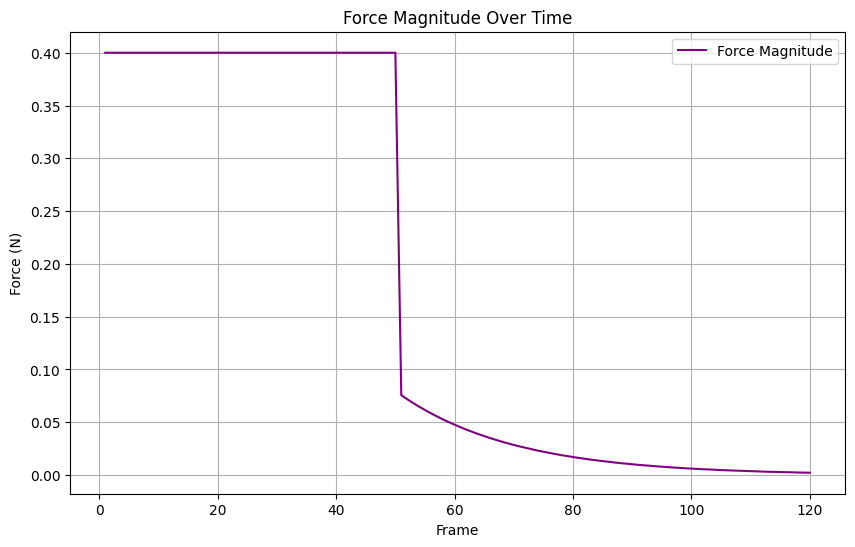

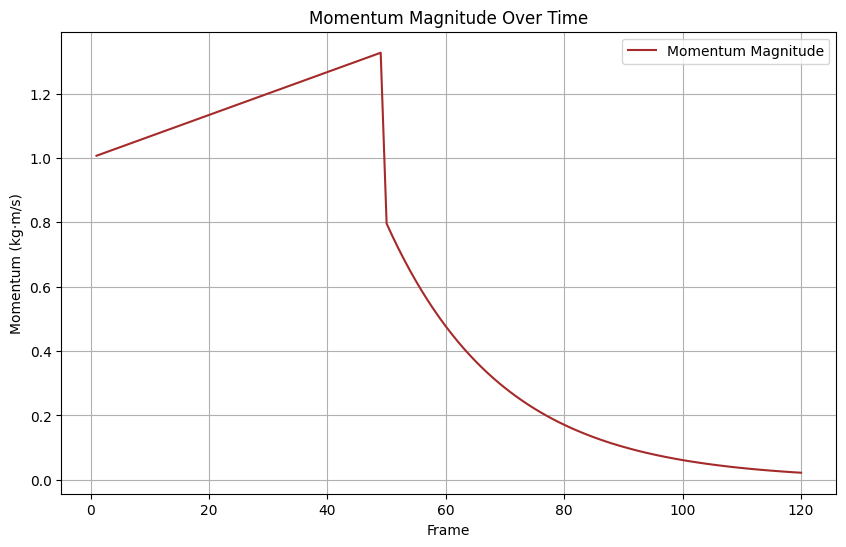

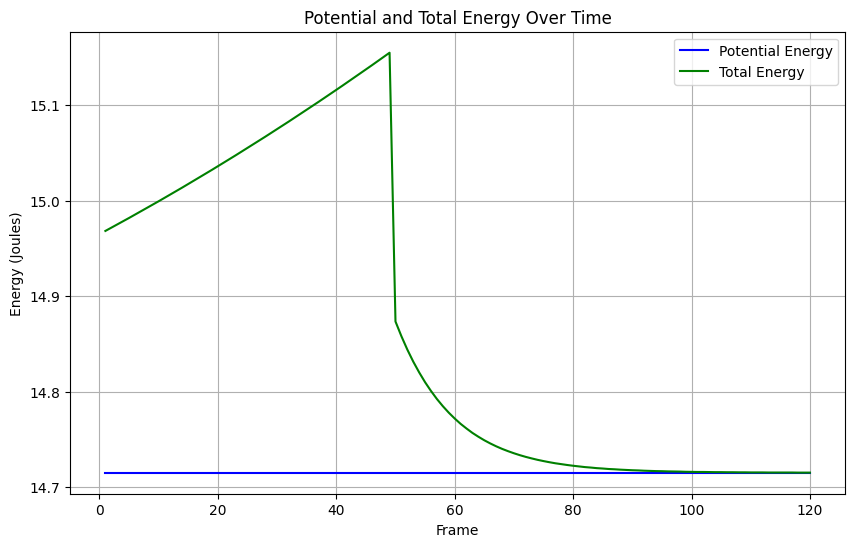

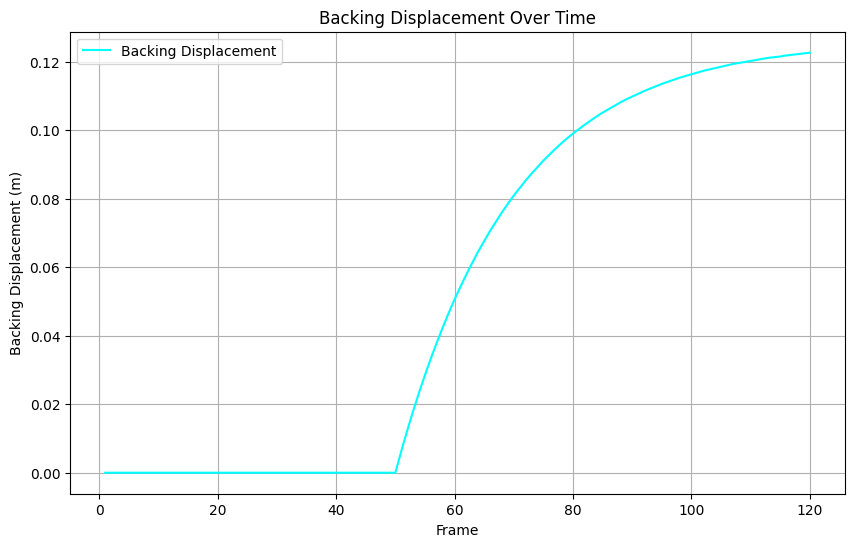

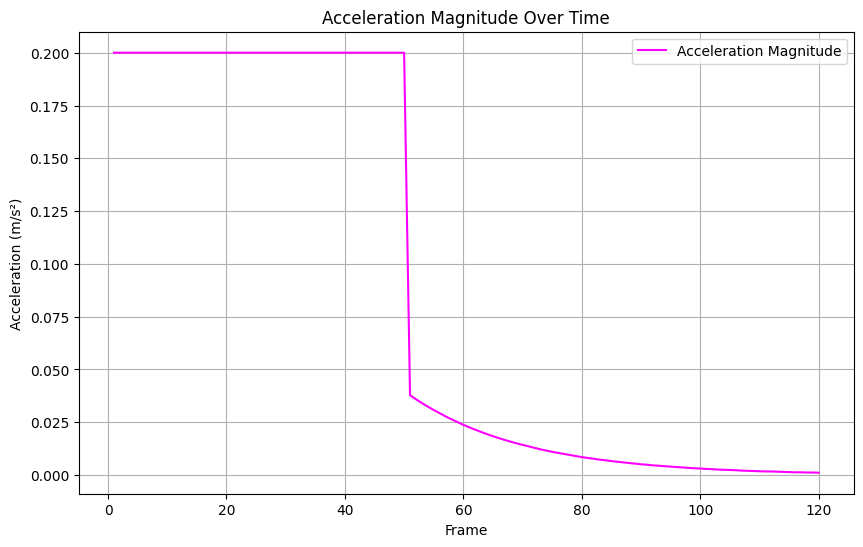

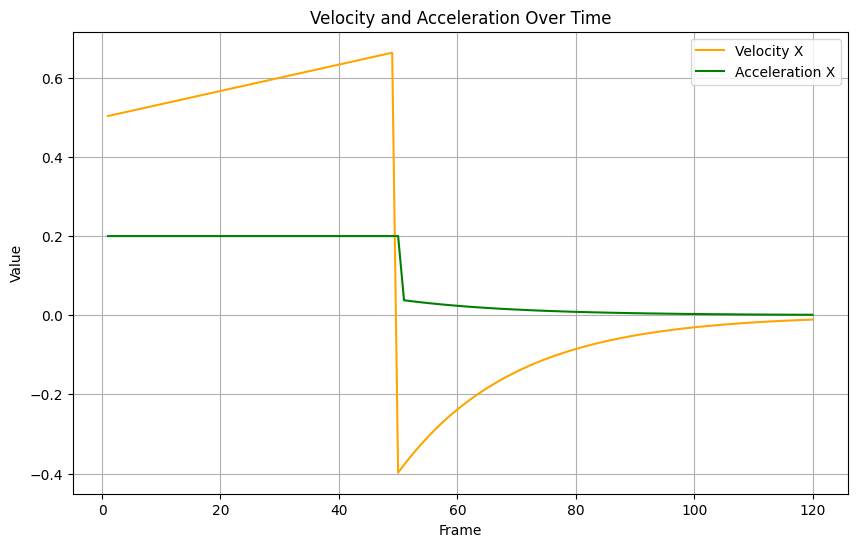

In [10]:
import matplotlib.pyplot as plt

# Force Magnitude over Time
plt.figure(figsize=(10,6))
plt.plot(df['Frame'], df['Force_Magnitude'], label='Force Magnitude', color='purple')
plt.xlabel('Frame')
plt.ylabel('Force (N)')
plt.title('Force Magnitude Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Momentum Magnitude over Time
plt.figure(figsize=(10,6))
plt.plot(df['Frame'], df['Momentum_Magnitude'], label='Momentum Magnitude', color='brown')
plt.xlabel('Frame')
plt.ylabel('Momentum (kg·m/s)')
plt.title('Momentum Magnitude Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Potential Energy and Total Energy Over Time
plt.figure(figsize=(10,6))
plt.plot(df['Frame'], df['Potential_Energy'], label='Potential Energy', color='blue')
plt.plot(df['Frame'], df['Total_Energy'], label='Total Energy', color='green')
plt.xlabel('Frame')
plt.ylabel('Energy (Joules)')
plt.title('Potential and Total Energy Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Backing Displacement Over Time
plt.figure(figsize=(10,6))
plt.plot(df['Frame'], df['Backing_Displacement'], label='Backing Displacement', color='cyan')
plt.xlabel('Frame')
plt.ylabel('Backing Displacement (m)')
plt.title('Backing Displacement Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Acceleration Magnitude Over Time
plt.figure(figsize=(10,6))
plt.plot(df['Frame'], df['Acc_Magnitude'], label='Acceleration Magnitude', color='magenta')
plt.xlabel('Frame')
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration Magnitude Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Combined Plot: Velocity and Acceleration
plt.figure(figsize=(10,6))
plt.plot(df['Frame'], df['Velocity_X'], label='Velocity X', color='orange')
plt.plot(df['Frame'], df['Acceleration_X'], label='Acceleration X', color='green')
plt.xlabel('Frame')
plt.ylabel('Value')
plt.title('Velocity and Acceleration Over Time')
plt.grid(True)
plt.legend()
plt.show()